import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Read data from 'input_dataset-2.parquet' and 'prediction_input.parquet' using 'pyarrow'

In [2]:
data_set_initial = pd.read_parquet('input_dataset-2.parquet', engine='pyarrow')
predict_set_initial = pd.read_parquet('prediction_input.parquet', engine='pyarrow')

Let's check NaN value count

In [3]:
data_set_initial.isnull().sum()

Unit_4_Power                      124087
Unit_4_Reactive Power             124087
Turbine_Guide Vane Opening        124087
Turbine_Pressure Drafttube        124087
Turbine_Pressure Spiral Casing    124087
Turbine_Rotational Speed          124087
mode                                   0
Bolt_1_Steel tmp                  124087
Bolt_1_Tensile                    124087
Bolt_2_Tensile                    124087
Bolt_3_Tensile                    124087
Bolt_4_Tensile                    124087
Bolt_5_Tensile                    124087
Bolt_6_Tensile                    124087
Bolt_1_Torsion                    124087
Bolt_2_Torsion                    124087
Bolt_3_Torsion                    124087
Bolt_4_Torsion                    124087
Bolt_5_Torsion                    124087
Bolt_6_Torsion                    124087
lower_bearing_vib_vrt             806069
turbine_bearing_vib_vrt           806069
dtype: int64

So, there are lots of NaN value for 'lower_bearing_vib_vrt' and 'turbine_bearing_vib_vrt'

Let's ignore those 'lower_bearing_vib_vrt' and 'turbine_bearing_vib_vrt'

In [4]:
data_set_initial = data_set_initial[['Unit_4_Power','Unit_4_Reactive Power','Turbine_Guide Vane Opening','Turbine_Pressure Drafttube','Turbine_Pressure Spiral Casing','Turbine_Rotational Speed','mode','Bolt_1_Steel tmp','Bolt_1_Tensile','Bolt_2_Tensile','Bolt_3_Tensile','Bolt_4_Tensile','Bolt_5_Tensile','Bolt_6_Tensile']]

Check predict data set

In [5]:
predict_set_initial.isnull().sum()

Unit_4_Power                      0
Unit_4_Reactive Power             0
Turbine_Guide Vane Opening        0
Turbine_Pressure Drafttube        0
Turbine_Pressure Spiral Casing    0
Turbine_Rotational Speed          0
mode                              0
dtype: int64

In [6]:
data_set_initial = data_set_initial.interpolate()

In [7]:
data_set_initial.isnull().sum()

Unit_4_Power                      0
Unit_4_Reactive Power             0
Turbine_Guide Vane Opening        0
Turbine_Pressure Drafttube        0
Turbine_Pressure Spiral Casing    0
Turbine_Rotational Speed          0
mode                              0
Bolt_1_Steel tmp                  0
Bolt_1_Tensile                    0
Bolt_2_Tensile                    0
Bolt_3_Tensile                    0
Bolt_4_Tensile                    0
Bolt_5_Tensile                    0
Bolt_6_Tensile                    0
dtype: int64

Convert these mode from text to numbers (0 for operation, 1 for start)

In [8]:
predict_set = predict_set_initial.replace(to_replace ="operation",value =0)
predict_set_final = predict_set.replace(to_replace ="start",value =1)

data_set = data_set_initial.replace(to_replace ="operation",value =0)
data_set_final = data_set.replace(to_replace ="start",value =1)

Function to create a test set

In [9]:
from sklearn.model_selection import train_test_split

Split data_set to train_set and test_set

In [10]:
train_set, test_set = train_test_split(data_set_final, test_size=0.2, random_state=42)

In [12]:
len(train_set)

1499269

X and Y are taken for the train_set inputs and outputs

In [13]:
X = train_set[['Unit_4_Power','Unit_4_Reactive Power','Turbine_Guide Vane Opening','Turbine_Pressure Drafttube','Turbine_Pressure Spiral Casing','Turbine_Rotational Speed','mode',]]

In [14]:
Y = train_set[['Bolt_1_Tensile','Bolt_2_Tensile','Bolt_3_Tensile','Bolt_4_Tensile','Bolt_5_Tensile','Bolt_6_Tensile']]

Check length of test_set

In [15]:
len(test_set)

374818

Check available modes

In [16]:
train_set['mode'].value_counts()

0    1494952
1       4317
Name: mode, dtype: int64

In [17]:
X_new = X.to_numpy()

In [18]:
Y_new = Y.to_numpy()

Apply Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lin_reg = LinearRegression()

In [21]:
lin_reg.fit(X_new,Y_new)

LinearRegression()

In [22]:
x_test = test_set[['Unit_4_Power','Unit_4_Reactive Power','Turbine_Guide Vane Opening','Turbine_Pressure Drafttube','Turbine_Pressure Spiral Casing','Turbine_Rotational Speed','mode',]]

In [23]:
x_test_new = x_test.to_numpy()

In [24]:
y_test = test_set[['Bolt_1_Tensile','Bolt_2_Tensile','Bolt_3_Tensile','Bolt_4_Tensile','Bolt_5_Tensile','Bolt_6_Tensile']]

In [25]:
y_test_new = y_test.to_numpy()

In [26]:
y_test_new_predicted = lin_reg.predict(x_test_new)

Let’s measure this regression model’s RMSE

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
lin_mse = mean_squared_error(y_test_new, y_test_new_predicted)

In [29]:
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5.1154452259219045

Let’s train a DecisionTreeRegressor

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_new, Y_new)

DecisionTreeRegressor()

Now that the model is trained, let’s evaluate it on the training set

In [32]:
y_test_new_predicted = tree_reg.predict(x_test_new)

In [33]:
tree_mse = mean_squared_error(y_test_new, y_test_new_predicted)

In [34]:
tree_rmse = np.sqrt(tree_mse)

In [35]:
tree_rmse

0.4954417460627697

Seems like this model really good. Let's use Cross-Validation using Scikit-Learn’s K-fold cross-validation

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
scores = cross_val_score(tree_reg, X_new, Y_new, scoring="neg_mean_squared_error", cv=10)

In [38]:
tree_rmse_scores = np.sqrt(-scores)

Let’s look at the results

In [39]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [40]:
display_scores(tree_rmse_scores)

Scores: [0.49055486 0.47733455 0.51308635 0.48741176 0.51196659 0.542133
 0.52281204 0.4896762  0.51244615 0.48394752]
Mean: 0.5031369018744984
Standard deviation: 0.019473559477449835


Let’s compute the same scores for the Linear Regression model

In [41]:
lin_scores = cross_val_score(lin_reg, X_new, Y_new, scoring = 'neg_mean_squared_error', cv = 10)

In [42]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [43]:
display_scores(lin_rmse_scores)

Scores: [5.10783499 5.12766712 5.11483909 5.11426788 5.11327216 5.13480248
 5.12837821 5.10918729 5.11838555 5.1139287 ]
Mean: 5.118256346419651
Standard deviation: 0.008525343119757087


Linear Regression model shows a lower deviation. So, the DecisionTreeRegressor is overfitted

So, the selected model is Linear Regression. Lets build the prediction

In [44]:
predict_set_final

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,0
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,0
1971-01-25 11:06:51,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,0
1971-01-25 11:06:52,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,0
1971-01-25 11:06:53,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,0
...,...,...,...,...,...,...,...
1971-02-03 20:16:19,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,0
1971-02-03 20:16:20,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,0
1971-02-03 20:16:21,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,0


In [45]:
predict_set_final_X = predict_set_final.to_numpy()

In [46]:
predict_set_final_X

array([[ 308.86786809,    5.59226085,   94.44235057, ..., 5279.87658082,
         108.05746682,    0.        ],
       [ 308.89823675,    6.25196927,   94.44568749, ..., 5279.93084307,
         108.05746049,    0.        ],
       [ 308.92860541,    7.0370913 ,   94.44902441, ..., 5279.98510533,
         108.05745417,    0.        ],
       ...,
       [ 107.48761775,  -21.59278364,   43.0379251 , ..., 5419.63398777,
         106.7229858 ,    0.        ],
       [ 104.45474113,  -22.27420816,   42.12115085, ..., 5420.0942374 ,
         106.71106977,    0.        ],
       [ 101.4218645 ,  -22.95563268,   41.20437659, ..., 5421.38596292,
         106.69915374,    0.        ]])

In [47]:
result = lin_reg.predict(predict_set_final_X)

In [48]:
result

array([[1616.74012484, 1492.30343942, 1691.76278048, 1604.28343349,
        1638.56937442, 1681.71529184],
       [1616.64812121, 1492.25460124, 1691.73035224, 1604.29204801,
        1638.58526872, 1681.70070147],
       [1616.52790852, 1492.18990385, 1691.68747733, 1604.3003846 ,
        1638.60188158, 1681.67836812],
       ...,
       [1502.64724257, 1422.972063  , 1645.05262942, 1573.20220406,
        1606.23206623, 1622.20108127],
       [1502.13271981, 1422.6515415 , 1644.83502434, 1572.90547972,
        1605.9512236 , 1621.83373477],
       [1501.60315822, 1422.32639407, 1644.60898523, 1572.60299463,
        1605.66852625, 1621.45793185]])

Convert result to dataframe

In [50]:
result_df = pd.DataFrame(result, columns = ['Bolt_1_Tensile','Bolt_2_Tensile','Bolt_3_Tensile','Bolt_4_Tensile','Bolt_5_Tensile','Bolt_6_Tensile'])

In [51]:
result_df.index = predict_set_final.index

In [52]:
result_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,
1971-01-25 11:06:49,1616.740125,1492.303439,1691.762780,1604.283433,1638.569374,1681.715292
1971-01-25 11:06:50,1616.648121,1492.254601,1691.730352,1604.292048,1638.585269,1681.700701
1971-01-25 11:06:51,1616.527909,1492.189904,1691.687477,1604.300385,1638.601882,1681.678368
1971-01-25 11:06:52,1616.407696,1492.125206,1691.644602,1604.308721,1638.618494,1681.656035
1971-01-25 11:06:53,1616.267124,1492.048479,1691.593820,1604.313036,1638.630438,1681.624172
...,...,...,...,...,...,...
1971-02-03 20:16:19,1503.671436,1423.611861,1645.485003,1573.793586,1606.793175,1622.932941
1971-02-03 20:16:20,1503.158959,1423.291721,1645.268661,1573.497854,1606.512563,1622.566850
1971-02-03 20:16:21,1502.647243,1422.972063,1645.052629,1573.202204,1606.232066,1622.201081


In [53]:
result_df.to_csv('result.csv')

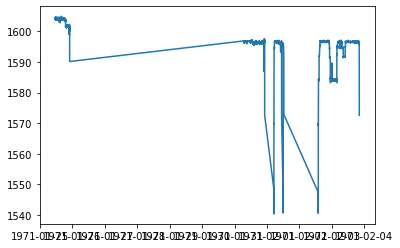

In [54]:
plt.plot(result_df['Bolt_4_Tensile'])